<h1>Deep-dentistry model for decay analysis</h1>

In [2]:
#Setting up resources and libraries required

import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten, Dense
from keras.layers.convolutional import *
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

In [3]:
#Local and relative paths to the files are used..
train_path = 'Data/train'
valid_path = 'Data/validate'
test_path = 'Data/test'

In [4]:
train_bconvert = ImageDataGenerator().flow_from_directory(train_path,target_size=(64,64),classes=['DECAYED','DECAYFREE'],batch_size=20)
valid_bconvert = ImageDataGenerator().flow_from_directory(valid_path,target_size=(64,64),classes=['DECAYED','DECAYFREE'],batch_size=10)
test_bconvert = ImageDataGenerator().flow_from_directory(test_path,target_size=(64,64),classes=['DECAYED','DECAYFREE'],batch_size=20)

Found 1081 images belonging to 2 classes.
Found 250 images belonging to 2 classes.
Found 596 images belonging to 2 classes.


In [5]:
# Function plots images with labels
def plots(ims, figsize=(24,12), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [6]:
imgs, labels = next(train_bconvert)

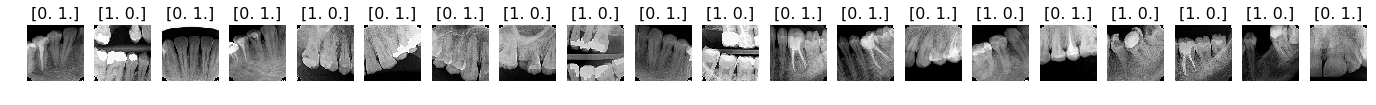

In [7]:
plots(imgs, titles=labels)

<h2>Network Architecture</h2>

In [12]:
input1 = keras.layers.Input(shape=(64, 64, 3))
C1 = Conv2D(32, (3, 3), strides=(2, 2), activation='linear', input_shape=(64,64,3),
                kernel_regularizer=regularizers.l2(9.999999747378752e-05), padding='valid')(input1)
BN1 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C1)
A1 = Activation('relu')(BN1)
C2=Conv2D(64, (3, 3), strides=(1, 1), activation='linear', input_shape=(64,64,3),
                kernel_regularizer=regularizers.l2(9.999999747378752e-05), padding='same')(A1)
BN2 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C2)
A2 = Activation('relu')(BN2)
C_sep_1 = SeparableConv2D(64, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A2)
BN3 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_1)
add_1 = keras.layers.add([A2,BN3])
A3 = Activation('relu')(add_1)

#Bottleneck 1

C3 = Conv2D(128, (7, 7), strides=(1, 1), activation='linear', input_shape=(64,64,3),
                kernel_regularizer=regularizers.l2(9.999999747378752e-05), padding='same')(A3)
BN4 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C3)
A4 = Activation('relu')(BN4)
C_sep_2 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A4)
BN5 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_2)
add_2= keras.layers.add([A4,BN5])
A5 = Activation('relu')(add_2)
C_sep_3 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A5)
BN6 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_3)
add_3= keras.layers.add([A5,BN6])
A6 = Activation('relu')(add_3)
C_sep_4 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A6)
BN7 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_4)
add_4= keras.layers.add([A6,BN7])
A7 = Activation('relu')(add_4)
C_sep_5 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A7)
BN8 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_5)
add_5= keras.layers.add([A4,BN8])
A8 = Activation('relu')(add_5)

#Bottleneck 2
MP1 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid',data_format='channels_last')(A8)
#To tackle overfitting as acc=0.998 and val_acc = 0.66  in previous version
DO1 = keras.layers.Dropout(rate=0.3, noise_shape=None, seed=None) (MP1)
C_sep_6 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(DO1)
BN9 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_6)
add_6= keras.layers.add([BN9,DO1])
A9 = Activation('relu')(add_6)

C4 = Conv2D(128, (7, 7), strides=(1, 1), activation='linear', input_shape=(64,64,3),
                kernel_regularizer=regularizers.l2(9.999999747378752e-05), padding='same')(A9)
BN10 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C4)
A10 = Activation('relu')(BN10)
C_sep_7 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A10)
BN11 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_7)
add_7= keras.layers.add([A10,BN11])
A11 = Activation('relu')(add_7)

C_sep_8 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A11)
BN12 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_8)
add_8= keras.layers.add([A11,BN12])
A12 = Activation('relu')(add_8)

C_sep_9 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A12)
BN13 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_9)
add_9= keras.layers.add([A12,BN13])
A13 = Activation('relu')(add_9)

C_sep_10 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A13)
BN14 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_10)
add_10= keras.layers.add([A10,BN14])

A14 = Activation('relu')(add_10)

#Bottleneck3
MP2 = MaxPooling2D(pool_size=(2,2),strides=(2,2),padding='valid',data_format='channels_last')(A14)
#To tackle overfitting as acc=0.95 and val_acc = 0.69  in previous version
DO2 = keras.layers.Dropout(rate=0.3, noise_shape=None, seed=None) (MP2)

C_sep_11 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(DO2)
BN15 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_11)
add_11= keras.layers.add([BN15,DO2])
A15 = Activation('relu')(add_11)
C5 = Conv2D(128, (7, 7), strides=(1, 1), activation='linear', input_shape=(64,64,3),
                kernel_regularizer=regularizers.l2(9.999999747378752e-05), padding='same')(A15)
BN16 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C5)
A16 = Activation('relu')(BN16) #Big Node 2

C_sep_12 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A16)
BN17 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_12)
add_12= keras.layers.add([A16,BN17])  #add_7
A17 = Activation('relu')(add_12) 

C_sep_13 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A17)
BN18 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_13)
add_13= keras.layers.add([A17,BN18])  #add_8
A18 = Activation('relu')(add_13) 

C_sep_14 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A18)
BN19 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_14)
add_14= keras.layers.add([A18,BN19])  #add_9
A19 = Activation('relu')(add_14) 

C_sep_15 = SeparableConv2D(128, (3, 3),dilation_rate=(1, 1), depth_multiplier=1, strides=(1, 1),padding='same',
            activation='linear',depthwise_initializer='Zeros', kernel_regularizer=regularizers.l2(9.999999747378752e-05),
                         use_bias=True, pointwise_initializer='glorot_uniform', bias_initializer='zeros', 
                          depthwise_regularizer=regularizers.l2(9.999999747378752e-05), pointwise_regularizer=regularizers.l2(9.999999747378752e-05))(A19)
BN20 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C_sep_15)
add_15= keras.layers.add([A16,BN20])  #add_9
A20 = Activation('relu')(add_15)

C6 = Conv2D(128, (7, 7), strides=(1, 1), activation='linear', input_shape=(64,64,3),
                kernel_regularizer=regularizers.l2(9.999999747378752e-05), padding='same')(A20)
BN21 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(C6)
A21 = Activation('relu')(BN21)
F1 = Flatten() (A21)
D1 = keras.layers.Dense(units=128, activation='linear', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
                        kernel_regularizer=regularizers.l2(9.999999747378752e-05))(F1)
BN22 = BatchNormalization(axis=-1, epsilon=0.001, mode=0, momentum=0.99, weights=None)(D1)
A22 = Activation('relu')(BN22)
DO3 = keras.layers.Dropout(rate=0.5, noise_shape=None, seed=None)(A22)
out = keras.layers.Dense(units=2, activation='softmax', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', 
                        kernel_regularizer=None)(DO3)
model = keras.models.Model(inputs=[input1], outputs=out)

C:\Users\DesignerBe\AppData\Local\conda\conda\envs\MLDL_env\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=-1, epsilon=0.001, momentum=0.99, weights=None)`
  after removing the cwd from sys.path.
C:\Users\DesignerBe\AppData\Local\conda\conda\envs\MLDL_env\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=-1, epsilon=0.001, momentum=0.99, weights=None)`
  
C:\Users\DesignerBe\AppData\Local\conda\conda\envs\MLDL_env\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=-1, epsilon=0.001, momentum=0.99, weights=None)`
  
C:\Users\DesignerBe\AppData\Local\conda\conda\envs\MLDL_env\lib\site-packages\ipykernel_launcher.py:22: UserWarning: Update your `BatchNormalization` call to the Keras 2 API: `BatchNormalization(axis=-1, epsil

In [13]:
model.compile(Adam(lr=.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 31, 31, 32)   896         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 31, 31, 32)   128         conv2d_5[0][0]                   
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 31, 31, 32)   0           batch_normalization_16[0][0]     
__________________________________________________________________________________________________
conv2d_6 (

In [11]:
for layer in model.layers:
    g=layer.get_config()
    h=layer.get_weights()
    print (g)
    print (h)

{'batch_input_shape': (None, 64, 64, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_1'}
[]
{'name': 'conv2d_1', 'trainable': True, 'batch_input_shape': (None, 64, 64, 3), 'dtype': 'float32', 'filters': 32, 'kernel_size': (3, 3), 'strides': (2, 2), 'padding': 'valid', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 9.999999747378752e-05}}, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[[[ 7.42815733e-02, -2.07459405e-02,  1.32754996e-01,
          -7.37847388e-02,  5.68770915e-02, -1.06634945e-02,
           1.27182469e-01,  8.06067139e-02,  2.51204520e-02,
          -8.84796679e-03, -5.93

{'name': 'separable_conv2d_1', 'trainable': True, 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'class_name': 'Zeros', 'config': {}}, 'pointwise_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'depthwise_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 9.999999747378752e-05}}, 'pointwise_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 9.999999747378752e-05}}, 'depthwise_constraint': None, 'pointwise_constraint': None}
[array([[[[0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
         [0.],
    

{'name': 'separable_conv2d_3', 'trainable': True, 'filters': 128, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'class_name': 'Zeros', 'config': {}}, 'pointwise_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'depthwise_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 9.999999747378752e-05}}, 'pointwise_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 9.999999747378752e-05}}, 'depthwise_constraint': None, 'pointwise_constraint': None}
[array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
  

{'name': 'separable_conv2d_6', 'trainable': True, 'filters': 128, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'class_name': 'Zeros', 'config': {}}, 'pointwise_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'depthwise_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 9.999999747378752e-05}}, 'pointwise_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 9.999999747378752e-05}}, 'depthwise_constraint': None, 'pointwise_constraint': None}
[array([[[[0.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [0.]],

        [[0.],
         [0.],
  

       1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)]
{'name': 'activation_10', 'trainable': True, 'activation': 'relu'}
[]
{'name': 'separable_conv2d_7', 'trainable': True, 'filters': 128, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'linear', 'use_bias': True, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'bias_regularizer': None, 'activity_regularizer': None, 'bias_constraint': None, 'depth_multiplier': 1, 'depthwise_initializer': {'class_name': 'Zeros', 'config': {}}, 'pointwise_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'depthwise_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 9.999999747378752e-05}}, 'pointwise_regularizer': {'class_name': 'L1L2', 'config': {'l1': 0.0, 'l2': 9.999999747378752e-05}}, 'depthwise_constraint': None, 'pointwise_constraint': None}
[array([[

{'name': 'batch_normalization_13', 'trainable': True, 'axis': -1, 'momentum': 0.99, 'epsilon': 0.001, 'center': True, 'scale': True, 'beta_initializer': {'class_name': 'Zeros', 'config': {}}, 'gamma_initializer': {'class_name': 'Ones', 'config': {}}, 'moving_mean_initializer': {'class_name': 'Zeros', 'config': {}}, 'moving_variance_initializer': {'class_name': 'Ones', 'config': {}}, 'beta_regularizer': None, 'gamma_regularizer': None, 'beta_constraint': None, 'gamma_constraint': None}
[array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 

{'name': 'dense_1', 'trainable': True, 'units': 2, 'activation': 'softmax', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}
[array([[-0.02689167, -0.01078583],
       [-0.01037381,  0.02613532],
       [-0.00688134,  0.02128256],
       ...,
       [ 0.01852953,  0.01511767],
       [ 0.01886596, -0.01959814],
       [ 0.02098321,  0.00955082]], dtype=float32), array([0., 0.], dtype=float32)]


In [24]:
model.fit_generator(train_bconvert, steps_per_epoch=55, 
                    validation_data=valid_bconvert, validation_steps=25, epochs=5, verbose=2) 

Epoch 1/5
 - 154s - loss: 0.7171 - acc: 0.8518 - val_loss: 1.6777 - val_acc: 0.6920
Epoch 2/5
 - 93s - loss: 0.5907 - acc: 0.8827 - val_loss: 0.8671 - val_acc: 0.7720
Epoch 3/5
 - 68s - loss: 0.5116 - acc: 0.9027 - val_loss: 0.6938 - val_acc: 0.8400
Epoch 4/5
 - 75s - loss: 0.4692 - acc: 0.9200 - val_loss: 0.6306 - val_acc: 0.8720
Epoch 5/5
 - 87s - loss: 0.4773 - acc: 0.8957 - val_loss: 0.6624 - val_acc: 0.8240


<h2>Results</h2>

In [17]:
test_bconf = ImageDataGenerator().flow_from_directory(test_path,target_size=(64,64),classes=['DECAYED','DECAYFREE'],batch_size=100)
test_imgs, test_labels = next(test_bconf)

Found 596 images belonging to 2 classes.


In [18]:
test_labels = test_labels[:,0]
test_labels

array([0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.,
       1., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0.,
       0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 1.,
       0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1.],
      dtype=float32)

In [25]:
predictions = model.predict_generator(test_bconf, steps=1, verbose=0)


In [ ]:
predictions

In [26]:
predictions=np.round(predictions,0)

In [27]:
cm = confusion_matrix(test_labels, predictions[:,0])

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[40 14]
 [ 2 44]]


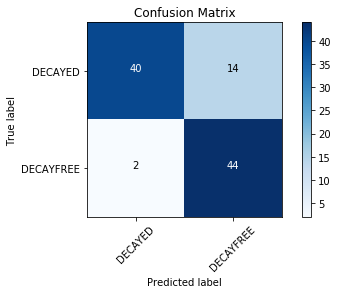

In [29]:
cm_plot_labels = ['DECAYED','DECAYFREE']
plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')